## Creating a ConnectivityMatrix object of the C elegans connectome

In this example we use available data for the worm to create a ConnectivityMatrix object of its connectome at eight developmental points. This is based on Witvliet et al: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8756380/
Annotations and properties for the individual neurons are taken from wormatlas.org.

To begin, please download the excel file of neuron types from the following url and place it under "data":
https://www.wormatlas.org/images/NeuronType.xls

Next, download the wiring diagrams at each developmental stage listed at the following url:
https://wormwiring.org/pages/witvliet.html
Place all of them under "data" as well. Each file corresponds to a different age, as presented in the orginal publication listed above. In the final product, these will be listed simply as stage=1, stage=2, etc.

Instead of building the object from the raw Excel files, you can also simply load the connectome from the included hdf5 file. In that case, simply skip ahead to the heading "Loading the data from hdf5".


Otherwise, we begin by loading the data from the downloaded files using pandas

In [1]:
import pandas
import numpy
import glob
import conntility

fns = glob.glob("data/witvliet_2020*.xlsx")
stage = [int(_fn[19]) for _fn in fns]
idx = numpy.argsort(stage)

fns = [fns[_i] for _i in idx]
stage = [stage[_i] for _i in idx]
rn_dict = {"pre": "row", "post": "col"}

syns = [pandas.read_excel(_fn).set_index("type")
       for _fn in fns]
neurons = pandas.read_excel("data/NeuronType.xls")

syns_chem = pandas.concat([syn.loc["chemical"] for syn in syns],
                          axis=0, names=["stage"], keys=stage).reset_index().rename(columns=rn_dict)

syns_elec = pandas.concat([syn.loc["electrical"] for syn in syns],
                          axis=0, names=["stage"], keys=stage).reset_index().rename(columns=rn_dict)

We separate the chemical and gap junction connectome and do some minor reformatting.

In [2]:
syns_chem = syns_chem.pivot(index=["row", "col"], columns="stage", values="synapses").fillna(0).astype(int)
syns_elec = syns_elec.pivot(index=["row", "col"], columns="stage", values="synapses").fillna(0).astype(int)

display(syns_chem)

stage        1  2  3  4  5  6  7  8
row   col                          
ADAL  AIAL   0  0  0  0  0  1  2  0
      AIBL   0  0  0  0  0  1  2  0
      AIBR   1  1  0  1  0  0  1  0
      AIZL   0  0  0  1  0  0  0  0
      ASHL   0  0  0  0  1  0  0  0
...         .. .. .. .. .. .. .. ..
URYVR RMDVL  1  1  1  2  3  3  5  8
      SIBDR  0  0  0  0  0  0  1  1
      SIBVL  0  0  0  0  0  0  1  2
      SIBVR  0  0  0  0  0  0  0  1
      SMDVL  1  4  2  2  5  2  2  4

[3676 rows x 8 columns]

Now the index lists pre- and post-synaptic neuron (renamed "row" and "col" as that it what the code expects), while the columns list the number of synapses at the various stages.

Next, we need to convert the names of the neurons (and muscles?) to indices into a table of nodes. As that table, we want to use the DataFrame of neuron properties we loaded earlier. Unfortunately, some entries of the connectivity data are not represented in that DataFrame. (I think these are innervated muscles, but I am frankly not a worm expert).

Thus, we have to create additional rows for the missing entries. We will fill them with mostly "NaN", but a worm expert is invited to contribute something better here.

In [3]:
syns_all = pandas.concat([syns_chem, syns_elec], axis=0)
idxx = syns_all.index.to_frame()

used_neurons = idxx.reset_index(drop=True).unstack().drop_duplicates().values
missing = numpy.setdiff1d(used_neurons, neurons["Neuron"].values)

missing_df = pandas.DataFrame.from_records([
    dict([(k, {"Neuron": name,
               "Soma Region": "-",  # Placeholders for string-type properties
               "Span": "-",
               "AY Ganglion Designation": "-"}.get(k, numpy.NaN)) for k in neurons.columns])
    for name in missing
])
neurons = pandas.concat([neurons, missing_df], axis=0).reset_index(drop=True)

With that being done, we can now simply look up for each connection the indices of participating nodes in the table. The result is put into a separate DataFrame.

In [4]:
nrn_idxx = neurons["Neuron"].reset_index().set_index("Neuron")["index"]
edges_chem = syns_chem.index.to_frame().applymap(lambda x: nrn_idxx[x]).reset_index(drop=True)
edges_elec = syns_elec.index.to_frame().applymap(lambda x: nrn_idxx[x]).reset_index(drop=True)

display(edges_chem)

,row,col
0,0,10
1,0,12
2,0,13
3,0,20
4,0,43
...,...,...
3671,237,189
3672,237,215
3673,237,216
3674,237,217


We can now create ConnectivityMatrices. Inputs are three DataFrames:
1. The indices of the edges
2. The table of synapse counts at different stages for each edge (in the same order as input 1)
3. The table of vertex properties


In [5]:
M_chem = conntility.ConnectivityMatrix(edges_chem, edge_properties=syns_chem.reset_index(drop=True),
                                       vertex_properties=neurons, shape=(len(neurons), len(neurons)))
M_elec = conntility.ConnectivityMatrix(edges_elec, edge_properties=syns_elec.reset_index(drop=True),
                                       vertex_properties=neurons, shape=(len(neurons), len(neurons)))

We can also create an object that combines the representation of the chemical and electrical connectomes. To that end, we simply concatenate the tables of edge indices and properties. Additionally, we add a new edge property called "type", that is either "electrical" or "chemical".

In the future we hope to simplify this by implementing this functionality in an .add operator.

In [6]:
edge_indices = pandas.concat([
    M_chem._edge_indices,
    M_elec._edge_indices
], axis=0).reset_index(drop=True)

_edge_prop_c = M_chem._edges.copy()
_edge_prop_c["type"] = "chemical"
_edge_prop_e = M_elec._edges.copy()
_edge_prop_e["type"] = "electrical"
_edge_prop = pandas.concat([_edge_prop_c, _edge_prop_e], axis=0).reset_index(drop=True)

M_all = conntility.ConnectivityMatrix(edge_indices, edge_properties=_edge_prop,
                                     vertex_properties=neurons, shape=(len(neurons), len(neurons)))

We can save the objects to hdf5 files for future use.
This will overwrite a file included in this release, but the contents should be identical!

In [7]:
M_chem.to_h5("data/C_elegans_witvliet.h5", prefix="chemical")
M_elec.to_h5("data/C_elegans_witvliet.h5", prefix="electrical")
M_all.to_h5("data/C_elegans_witvliet.h5", prefix="combined")

/home/reimann/venvs/py38/lib/python3.8/site-packages/conntility/connectivity.py:1237: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  self._edges.to_hdf(fn, key=full_prefix + "/edges")
/home/reimann/venvs/py38/lib/python3.8/site-packages/conntility/connectivity.py:1237: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->integer,key->block0_items] [items->None]

  self._edges.to_hdf(fn, key=full_prefix + "/edges")


## Loading the data from hdf5

The next line loads the connectome data from an included hdf5 file. Use this if you do not want to (or cannot) download the use the raw Excel files.

In [8]:
M_chem = conntility.ConnectivityMatrix.from_h5("data/C_elegans_witvliet.h5", prefix="chemical")
M_elec = conntility.ConnectivityMatrix.from_h5("data/C_elegans_witvliet.h5", prefix="electrical")
M_all = conntility.ConnectivityMatrix.from_h5("data/C_elegans_witvliet.h5", prefix="combined")

We can now access the connectivity at different stages using the .default function.
As a basic validation, we confirm that the total synapse counts match expectation

In [9]:
total_counts_chem = syns_chem.sum(axis=0)

for stage, counts in total_counts_chem.items():
    assert M_chem.default(stage).array.sum() == counts
    assert M_chem.array_(stage).sum() == counts  # This is equivalent to the line above

Some notes about the "combined" connectome (M_all):

Some pairs of neurons have both chemical and electrical synapses between them. That is, M_all represents a graph with potentially multiple edges between nodes. The .array() (and .dense_matrix()) functions will return the sum of the number of chemical and electrical synapses.

In [10]:
for stage in total_counts_chem.keys():
    assert M_all.array_(stage).sum() == M_chem.array_(stage).sum() + M_elec.array_(stage).sum()

Since we attached the "type" property to the edges of M_all, we can get only the chemical or only the electrical connectome by using the .filter function on that property:

In [11]:
for stage in total_counts_chem.keys():
    # "filter" edges to keep only the ones where "type" is (eq)ual to "chemical"
    M_tmp = M_all.filter("type").eq("chemical")
    assert M_tmp.array_(stage).sum() == M_chem.array_(stage).sum()
    
for stage in total_counts_chem.keys():
    # "filter" edges to keep only the ones where "type" is (eq)ual to "chemical"
    M_tmp = M_all.filter("type").eq("electrical")
    assert M_tmp.array_(stage).sum() == M_elec.array_(stage).sum()

One caveat when accessing the adjacency as a sparse matrix using the .matrix property:
Connections that are not present at a given stage, but at other stages will be represented as edges, but with a value of "0" synapses associated with them. 

I will illustrate what that means below.

In [12]:
sparse_m = M_all.default(1).matrix

print("This matrix lists {0} edges. But only {1} of them are non-zero".format(
    sparse_m.nnz, (sparse_m > 0).nnz
))

This matrix lists 4297 edges. But only 849 of them are non-zero


There are three ways of dealing with it. 

The first is simply being aware of the issue in your analyses. For example, as it is only relevant in the sparse representation, it does not affect the results of the .array and .dense_matrix functions!

The second is to use the .filter function to only consider edges with a weight > 0. 

The third is to represent the data as a "StructurallyPlasticMatrix" instead. 

I illustrate the second option below, and the third one further down.

In [13]:
# Filter edges keeping only the ones with a weight (g)reater (t)han 0
sparse_m_filtered = M_chem.default(1).filter().gt(0)
sparse_m_filtered = sparse_m_filtered.matrix

print("This matrix lists {0} edges. And all {1} of them are non-zero".format(
    sparse_m_filtered.nnz, (sparse_m_filtered > 0).nnz
))

This matrix lists 775 edges. And all 775 of them are non-zero


Some stuff we can do now: Split up into subnetworks based on "Soma region" for stage 8.
That is, split into subgraphs on the nodes where the value of "Soma region" is a given string, and the edges between them.

In [14]:
M8 = M_all.default(8).filter().gt(0)
subnetworks = M8.partition("Soma Region")

for nw_name in subnetworks.index:
    print("Subnetwork {0} has {1} synapses".format(nw_name, subnetworks[nw_name].array.sum()))

Subnetwork ('-',) has 0 synapses
Subnetwork ('H',) has 6482 synapses
Subnetwork ('M',) has 43 synapses
Subnetwork ('T',) has 33 synapses


Number of connections between nodes associated with different soma regions.

Note: .condense returns the number of edges, ignoring their weight (synapse count). In the future, we might change this to return the sum of weights instead. 

In [15]:
print(M8.condense("Soma Region").array)

# Check consistency with the "subnetworks". condense is to count the number of edges, 
# i.e. the .nnz of the sparse representation
for i, nw_name in enumerate(subnetworks.index):
    assert subnetworks[nw_name].matrix.nnz == M8.condense("Soma Region").array[i, i]

[[   0    6    0    0]
 [ 245 1820   30   80]
 [   1   70   19   20]
 [   7  180    8   10]]


What numbers of synapses are contained in subnetworks based on soma position? We cumulatively increase the size of the network from head to tail.

Note: We filled in for the missing vertices a "Soma Position" value of NaN. These will be ignored in this analysis. 

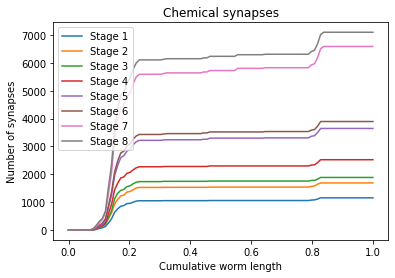

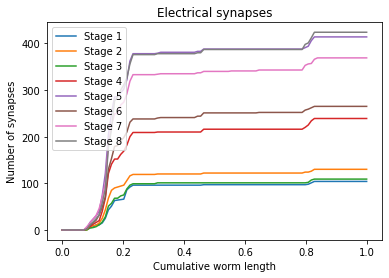

In [16]:
from matplotlib import pyplot as plt
import numpy

x = numpy.linspace(0, 1, 100)

ax = plt.figure().gca()
for stage in range(1, 9):
    M = M_chem.default(stage)
    y = [M.index("Soma Position").le(_x).array.sum()
         for _x in x]
    ax.plot(x, y, label="Stage {0}".format(stage))
ax.set_xlabel("Cumulative worm length")
ax.set_ylabel("Number of synapses")
ax.set_title("Chemical synapses")
plt.legend()

ax = plt.figure().gca()
for stage in range(1, 9):
    M = M_elec.default(stage)
    y = [M.index("Soma Position").le(_x).array.sum()
         for _x in x]
    ax.plot(x, y, label="Stage {0}".format(stage))
ax.set_xlabel("Cumulative worm length")
ax.set_ylabel("Number of synapses")
ax.set_title("Electrical synapses")
plt.legend()

Along the length of the worm: What is the fraction of electrical synapses at that position?

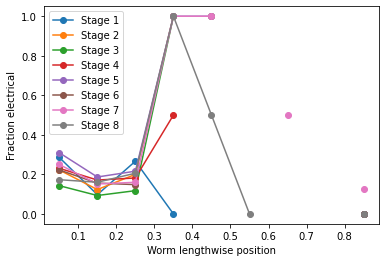

In [17]:
x = numpy.linspace(0, 1, 11)
plt_x = 0.5 * (x[:-1] + x[1:])

ax = plt.figure().gca()
for stage in range(1, 9):
    M = M_all.filter(stage).gt(0)
    # Filter position between _from and _to. Then fraction "electrical"
    y = [(M.index("Soma Position").ge(_from).index("Soma Position").lt(_to).edges["type"] == "electrical").mean()
         for _from, _to in zip(x[:-1], x[1:])]
    ax.plot(plt_x, y, label="Stage {0}".format(stage), marker="o")
ax.set_xlabel("Worm lengthwise position")
ax.set_ylabel("Fraction electrical")
plt.legend()

The data used to populate the "vertex properties" includes the number of synapses each neuron sends / receives from neurons in the head. This is from a very different connectivity data source than the Witvliet et al. data we loaded. We can compare synapse counts to this reference.

To that end, we use the .edge_associated_vertex_properties function to to get for each edge the region of the neuron sending / receiving the connection. Then we use .subedges to filter the connectivity, including only edges where the source or target are in the head.

,row,col
0,H,H
1,H,H
2,H,H
3,H,H
4,H,H
...,...,...
3671,H,H
3672,H,H
3673,H,H
3674,H,H


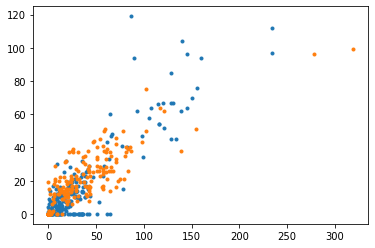

In [18]:
stage = 8
Mc = M_chem.default(8)
Me = M_elec.default(8)

# For each edge: region of the source (row) and target (col) neuron
src_tgt_region_c = Mc.edge_associated_vertex_properties("Soma Region") 
display(src_tgt_region_c)
src_tgt_region_e = Me.edge_associated_vertex_properties("Soma Region")

# Filter edges based on source and target regions
count_from_head = Mc.subedges(src_tgt_region_c["row"] == "H").array.sum(axis=0) + \
                  Me.subedges(src_tgt_region_e["row"] == "H").array.sum(axis=0)
count_to_head = Mc.subedges(src_tgt_region_c["col"] == "H").array.sum(axis=1) + \
                Me.subedges(src_tgt_region_e["col"] == "H").array.sum(axis=1)


plt.plot(count_from_head, M_chem.vertices["R_Head"].fillna(0).values, '.')
plt.plot(count_to_head, M_chem.vertices["S_Head"].fillna(0).values, '.')

### Using a StructurallyPlastixMatrix

As mentioned above, the data is arguably better represented as a StructurallyPlasticMatrix, as the changes in the data include appearance and disappearance of connections. (On the other hand, the data is eight individual snap shots of connectomes at different times and not a single connectome studied over time. Hence, a connection disappearing could be a genuine developmental step or just the two worms following different trajectories).

We can fairly easily create a StructurallyPlasticMatrix from one of the connectomes. A StructurallyPlasticMatrix needs in addition to the edge indices, edge properties and vertex properties two pandas Series describing at what points edges are switched on or off. We can easily determine that by finding changes in the columns of the edge properties. If an entry is zero for column i and nonzero for i+1, then it is gained at i+1; in the inverse case it is lost.

It is assumed that initially all edges are _on_, so we also need to determine which edges are off in the first step.

In [19]:
stage_cols = [_x for _x in M.edges.columns if isinstance(_x, int)]
M.edges[stage_cols]

stage,1,2,3,4,5,6,7,8
5,1,0,1,1,1,3,1,2
6,1,2,2,0,0,1,0,1
7,3,1,3,3,8,9,7,16
8,0,2,1,2,3,2,7,6
9,1,1,0,2,0,0,0,1
...,...,...,...,...,...,...,...,...
4276,0,1,0,1,4,1,1,1
4288,0,0,0,0,0,0,0,1
4289,0,0,0,0,0,0,2,1
4292,1,1,1,1,2,1,1,1


In [20]:
def to_structurally_plastic(M):
    stage_cols = [_x for _x in M.edges.columns if isinstance(_x, int)]
    edges = M.edges[stage_cols]
    start_off = (edges == 0)[1]
    start_off = pandas.Series(start_off.index[start_off].values,
                              index=[edges.columns[0]] * start_off.sum())  # List of edges that start being off
    switch_on = numpy.diff((edges > 0).astype(int), axis=1) > 0  # edges gained
    switch_off = numpy.diff((edges > 0).astype(int), axis=1) < 0  # edges lost

    idx_on = numpy.nonzero(switch_on)  # Get indices of changes
    idx_on = pandas.Series(idx_on[0], index=edges.columns[idx_on[1] + 1])

    idx_off = numpy.nonzero(switch_off)  # Same...
    idx_off = pandas.Series(idx_off[0], index=edges.columns[idx_off[1] + 1])
    idx_off = pandas.concat([start_off, idx_off], axis=0)  # Include the ones starting off

    M_plast = conntility.StructurallyPlasticMatrix(M._edge_indices, edge_properties=M._edges,
                                                  vertex_properties=M._vertex_properties, shape=M._shape,
                                                  edge_on=idx_on, edge_off=idx_off)
    return M_plast

M_chem_plast = to_structurally_plastic(M_chem)
M_elec_plast = to_structurally_plastic(M_elec)

# NOTE: For "StructurallyPlastic" matrices with multiple edges between nodes the behavior
# of some functionality is untested. Use at own risk and file a ticket if you encounter an error!
M_all_plast  = to_structurally_plastic(M_all)

The result can be indexed by developmental stage. Stage "0" is an artificial one where all edges are assumed active, hence it is equivalent to the non-structurally-plastic version:

In [21]:
numpy.all(M_chem_plast[0].array == M_chem.array)

True

We can then access the matrix at a given stage and it will not contain edges with zero weights. 

As a caveat, we manually have to use the .default function to make sure the correct weights for the selected stage are considered. Otherwise you might gain a matrix that is _structurally_ at the selected stage, but _functionally_ (in terms of weights) at a different one. We hope to simplify this in future releases.

In [22]:
M_at_6 = M_chem_plast[6].default(6)

print(M_at_6.matrix.data)  # No zeros
print(M.default(6).matrix.data[:10])  # This one has zeros

# Testing that M_at_6 is identical to the non-plastic version after an edge filter is applied as above
M_nonplast = M_chem.default(6).filter().gt(0)

assert numpy.all(M_nonplast.matrix.data == M_at_6.matrix.data)

[1 1 3 ... 9 3 2]
[3 1 9 2 0 0 3 0 4 1]


The StructurallyPlasticMatrix object offers a number of extra functionality. For example, we can easily count the number of time steps an edge is active in

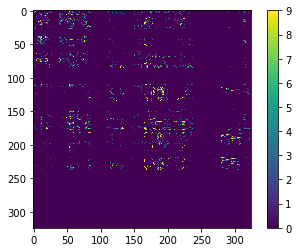

In [23]:
plt.colorbar(plt.imshow(M_chem_plast.amount_active().array, interpolation="nearest"))

Or we can get versions that ignore (i.e. skip) the structural changes happen between specified stages.

In [24]:
M_skip = M_chem_plast.skip(2, 5)

# Distribution of the number of active steps in the default data
display(pandas.Series(M_chem_plast.amount_active().matrix.data).value_counts())

# And if we ignore the changes between stages 2 and 5
display(pandas.Series(M_skip.amount_active().matrix.data).value_counts())

2    1440
3     700
9     442
4     379
5     231
6     171
8     167
7     146
Name: count, dtype: int64

2    1384
3     661
9     530
4     343
5     235
1     178
6     144
8     102
7      99
Name: count, dtype: int64

There is much more functionality. Explore and play around with it!